# Example code to run the proposed pose generation models

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

from genff.visualization.plotting import plot_sample, plot_sample_rect
from genff.data_handling.dataset import GroupDataset

# load up a dataset
dataset = GroupDataset("../data/cocktail_party/cocktail_party_test.h5", rect_repr=False)
print("Loaded dataset with {} samples".format(len(dataset)))

Loading ../data/cocktail_party/cocktail_party_test.h5
Loaded dataset with 347 samples


## Run model-based, geometric approach

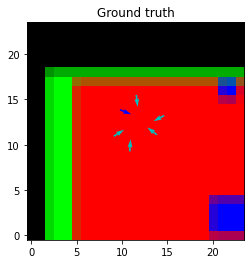

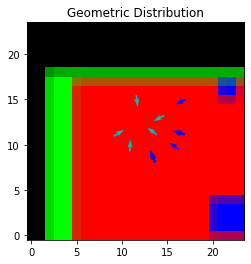

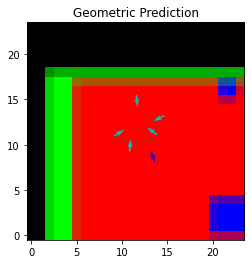

In [28]:
from genff.opt_method.opt_generator import opt_generator
import numpy as np
import matplotlib.pyplot as plt
import torch
from genff.mode_estimation.mode_estimation import find_modes

# initial locations for the optimization step
x = np.arange(-3, 3, 1.0)
y = np.arange(-3, 3, 1.0)
xv, yv = np.meshgrid(x, y)
x0 = np.stack((xv.flatten(),yv.flatten()), axis=1)

# prepare input data
gt_ind, context, mask, env = dataset[305]

# get sample predictions (computes distribution and outputs a single pose)
# (to use the single pose prediction mode, pass a single x0 sample instead of multiple ones)
gen_ind, final_losses, _ = opt_generator(context, mask, emap=env, eres=dataset.resolution,
                                         x0=x0, x_index=0, y_index=1, angle_index=2, ospace_dist=0.72,
                                         weight_psloss=1.25, weight_closs=0.2, weight_eloss=0.5,
                                         verbose=False)

# pick mode
if x0.shape[0] > 1:
    modes = find_modes(gen_ind, bandwidth=0.8, threshold=0.3, kappa=1.0)
    pred_ind = torch.from_numpy(modes[0]).unsqueeze(0)
else:
    best_index = np.argmin(final_losses)
    pred_ind = torch.from_numpy(gen_ind[best_index:best_index+1,:])

# plot gt and result (context is in green and robot's pose (individual) in blue)
plot_sample(gt_ind, context, mask, env_cropped=env, env_res=dataset.resolution)
plt.title("Ground truth")
plt.show()

plot_sample(torch.tensor(gen_ind), context, mask, env_cropped=env, env_res=dataset.resolution)
plt.title("Geometric Distribution")
plt.show()

plot_sample(pred_ind, context, mask, env_cropped=env, env_res=dataset.resolution)
plt.title("Geometric Prediction")
plt.show()

## Run data-driven approach

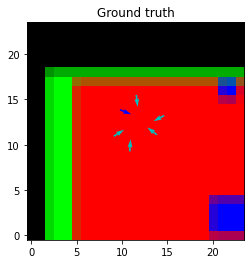

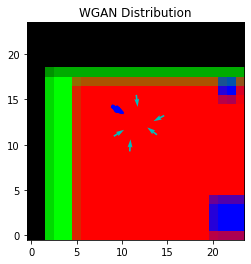

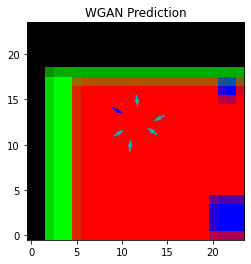

In [29]:
from genff.gan_method.networks import GenNet
from genff.data_handling.transform import RectangularAngle
import json

def load_args(path):
    # load saved params
    with open(path, 'r') as fid:
        return json.load(fid)
    
# transform for the angle -> cos(angle), sin(angle)
rect_angle = RectangularAngle(angle_index=2)
    
# path to model files
model_path = "../wgan_models/igibson/igibson.pt"
args_path = "../wgan_models/igibson/args.txt"

# load up model
args = load_args(args_path)
generator = GenNet(args["grid_res"], args["grid_w"], args["grid_w"], sigma=args["plot_sigma"])
checkpoint = torch.load(model_path, map_location=torch.device('cpu')) 
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# prepare input data
gt_ind, context, mask, env = dataset[305:306] # batch of one sample
_, context_rect, _, _ = rect_angle((gt_ind, context, mask, env))

# get sample predictions (distribution mode)
dist_samples = []
for i in range(x0.shape[0]):
    pred_ind = generator(context_rect, mask, env)
    pred_ind = pred_ind.detach().squeeze(1).numpy()
    pose = np.zeros((pred_ind.shape[0], 3))
    pose[:, 0:2] = pred_ind[:, 0:2]
    pose[:, 2] = np.arctan2(pred_ind[:, 3], pred_ind[:, 2])
    dist_samples.append(pose)
dist_samples = np.vstack(dist_samples)

# compute final pose
modes = find_modes(dist_samples, bandwidth=0.8, threshold=0.3, kappa=1.0)
    
# plot gt and result (context is in green and robot's pose (individual) in blue)
plot_sample(gt_ind[0], context[0], mask[0], env_cropped=env[0], env_res=dataset.resolution)
plt.title("Ground truth")
plt.show()

plot_sample(torch.tensor(dist_samples), context[0], mask[0], env_cropped=env[0], env_res=dataset.resolution)
plt.title("WGAN Distribution")
plt.show()

plot_sample(torch.tensor(modes[0]).unsqueeze(0), context[0], mask[0], env_cropped=env[0], env_res=dataset.resolution)
plt.title("WGAN Prediction")
plt.show()